In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from econml.metalearners import XLearner
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression


In [8]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Features (customer attributes)
X = np.random.normal(size=(n_samples, 3))  # 3 features

# Treatment assignment (randomly assigned)
T = np.random.binomial(1, 0.5, size=n_samples)  # 50% receive treatment

# Base outcome (spending without discount)
Y0 = 50 + 5 * X[:, 0] + 3 * X[:, 1] + np.random.normal(0, 5, size=n_samples)

# Treatment effect (discount effect varies by customers)
treatment_effect = 10 + 3 * X[:, 2]

# Outcome (spending with discount)
Y1 = Y0 + treatment_effect

# Observed outcome based on treatment
Y = Y1 * T + Y0 * (1 - T)

# Convert to DataFrame
df = pd.DataFrame(np.hstack((X, T.reshape(-1, 1), Y.reshape(-1, 1))),
                  columns=['Feature1', 'Feature2', 'Feature3', 'Treatment', 'Spending'])

print(df.head())


   Feature1  Feature2  Feature3  Treatment   Spending
0  0.496714 -0.138264  0.647689        1.0  64.917157
1  1.523030 -0.234153 -0.234137        1.0  72.726668
2  1.579213  0.767435 -0.469474        0.0  63.129197
3  0.542560 -0.463418 -0.465730        1.0  57.863289
4  0.241962 -1.913280 -1.724918        0.0  46.755965


In [11]:
# Split into train and test sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

# Define the base learners (Gradient Boosting Regressors)
model_treated = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
model_control = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

propensity_model = LogisticRegression()

# Define the X-Learner
x_learner = XLearner(models=(model_treated, model_control),
                      propensity_model=propensity_model)  # We assume equal treatment assignment probability

# Fit the X-Learner to estimate treatment effects
x_learner.fit(Y_train, T_train, X=X_train)

# Estimate the individual treatment effects (ITEs)
treatment_effects = x_learner.effect(X_test)



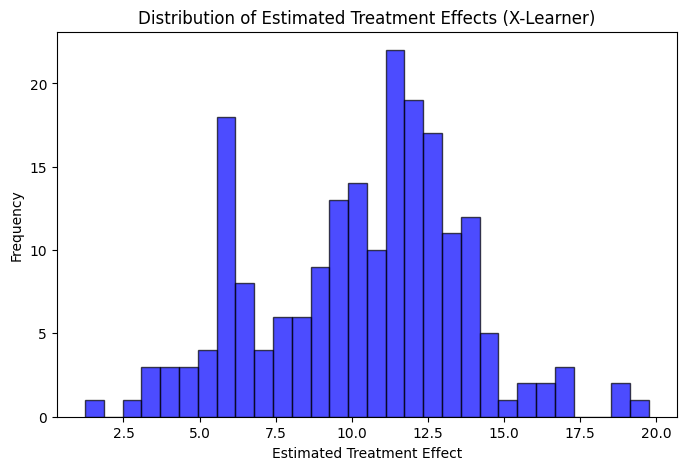

Example 1: Estimated Treatment Effect = 8.88
Example 2: Estimated Treatment Effect = 9.50
Example 3: Estimated Treatment Effect = 14.58
Example 4: Estimated Treatment Effect = 5.70
Example 5: Estimated Treatment Effect = 9.72


In [12]:
# Plot estimated treatment effects
plt.figure(figsize=(8, 5))
plt.hist(treatment_effects, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated Treatment Effects (X-Learner)")
plt.show()

# Print some example estimated treatment effects
for i in range(5):
    print(f"Example {i+1}: Estimated Treatment Effect = {treatment_effects[i]:.2f}")
